# RGI-07: Region 13
##### F. Maussion & S. Galos, June 2021

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from utils import mkdir

### specify RGI-region and storage paths

In [2]:
# specify RGI region of interest
reg = 13

# file path to level-2 processed input data for the region 
idir = '../l2_sel_reg_tars/'

# specify storage path for new RGI07-alpha-file
odir = mkdir('../l3_rgi7a')
odir_tar = mkdir('../l3_rgi7a_tar')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + idir + f'RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### Apply selection criteria to create the RGI-07 data subset

In [4]:
# try to get the data relevant for RGI07 and select by attributes
RGI_ss = shp.loc[shp['analysts'] == 'Sakai, Akiko']

## Write out and tar 

In [5]:
dd = mkdir(f'{odir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{odir_tar}/RGI{reg:02d}.tar.gz', '-C', odir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l3_rgi7a_tar/RGI13.tar.gz', '-C', '../l3_rgi7a', 'RGI13'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here GAMDAM original) to enable comparison

In [36]:
# specify path to reference data set
import zipfile
import glob
gam_files = glob.glob('suppportive_data_region_files/gamdam/*.zip')
df_ref = []
for gf in gam_files:
    # Just to know the name of the file to open from zip
    with zipfile.ZipFile(gf, "r") as z:
        for f in z.filelist:
            if '.shp' in f.filename:
                fname = f.filename
    df_ref.append(gpd.read_file('zip://' + gf + '/' + fname))

df_ref = pd.concat(df_ref).reset_index()

In [38]:
# Calculate representative points for reference data
ref_rp = df_ref.representative_point()

# Make a dataframe out of it and add the original index to recover it later
ref_rp = ref_rp.to_frame('geometry')
ref_rp['orig_index'] = df_ref.index

In [39]:
# Read region file
reg_f = gpd.read_file('../l0_regions/00_rgi70_regions/00_rgi70_O1Regions.shp')

In [40]:
# Make the overlay with the RGI region of interest -> get the rep. points which are located inside the region boundaries
ref_intersect = gpd.overlay(ref_rp, reg_f.loc[reg_f.RGI_CODE == f'{reg:02d}'], how='intersection')

In [41]:
# Now select the entries which intersect from the original shape file (-> extract the polygons) 
ref_odf = df_ref.loc[ref_intersect['orig_index'].values]

## Compare new RGI-file and reference data set 

### Number of elements (differences do not necessarily depict major problems)

In [42]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 75420
Number of glaciers in reference data: 75615
Difference: -195


### Total area

In [43]:
# add an area field to the selected GAMDAM table
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [44]:
# print and compare area values
Area_RGI = RGI_ss['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area Ref [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:',d)

Area RGI [km²]: 50344.57044713261
Area Ref [km²]: 50341.698431230056
Area difference [km²]: 2.872015902554267


### Identify potentially problematic cases and write them to a shapefile

In [14]:
# overlay RGI file with reference data set to evaluate differences (some computational effort)
delta_shape = gpd.overlay(RGI_ss, ref_odf , how='difference')

In [15]:
# add a column with the geometry area
delta_shape['area'] = delta_shape.to_crs({'proj':'cea'}).area

In [16]:
# extract all geometries larger than a threshold 
#10000 m² = 0,01 km² which is the common threshold for glaciers to be included in inventories
thr = 3000 
df_d = delta_shape.loc[delta_shape['area'] > thr]

In [17]:
df_d

,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,...,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,CenLon,CenLat,geometry
111253,glac_bound,541396.0,G071942E38870N,2018-07-01T00:00:00,3699.850508,129.72500,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,GEOMETRYCOLLECTION Z (LINESTRING Z (71.93344 3...
111458,glac_bound,541667.0,G072126E38989N,2018-07-01T00:00:00,13497.452927,677.82400,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"MULTIPOLYGON Z (((72.45818 38.79174 0.00000, 7..."
139831,glac_bound,603632.0,G079990E41931N,2018-07-01T00:00:00,6157.708757,266.47400,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,GEOMETRYCOLLECTION Z (LINESTRING Z (80.01565 4...
140212,glac_bound,604113.0,G080012E42227N,2018-07-01T00:00:00,4339.411799,151.12500,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"MULTIPOLYGON Z (((80.28455 42.25400 0.00000, 8..."
140819,glac_bound,604871.0,G079787E42137N,2018-07-01T00:00:00,8560.013039,474.30700,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"MULTIPOLYGON Z (((80.29509 42.05094 0.00000, 8..."
141327,glac_bound,605458.0,G080341E42280N,2018-07-01T00:00:00,3746.793998,150.33600,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,GEOMETRYCOLLECTION Z (LINESTRING Z (80.40262 4...
141589,glac_bound,605799.0,G080334E42156N,2018-07-01T00:00:00,4071.724632,189.60100,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,GEOMETRYCOLLECTION Z (LINESTRING Z (80.34423 4...
143242,glac_bound,607981.0,G080728E35377N,2018-07-01T00:00:00,3184.683429,211.55800,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,GEOMETRYCOLLECTION Z (LINESTRING Z (80.70916 3...
143663,glac_bound,608584.0,G080922E42305N,2018-07-01T00:00:00,3159.186180,124.78600,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,GEOMETRYCOLLECTION Z (LINESTRING Z (80.96090 4...
151202,glac_bound,618589.0,G083798E29250N,2018-07-01T00:00:00,511500.788679,2.09713,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"MULTIPOLYGON Z (((83.80979 29.25701 0.00000, 8..."


In [18]:
# create a file which contains the spatial features which were defined as problematic as above
prob_IDs = RGI_ss.loc[df_d.glac_id.isin(RGI_ss.glac_id).index]

# and write it to shapefile
td = f'{testout}/RGI_R{reg:02d}probs.shp'
prob_IDs.to_file(td)

### Do the same for the reference data set

In [19]:
# overlay the representative Points of refernce data and and the above geometries to identify the same glaciers
df_d_ref_p = gpd.overlay(ref_rp, prob_IDs, how='intersection')

In [20]:
 # Now select the entries which intersect from the original shape file (-> extract the polygons) 
df_d_ref = df_ref.loc[df_d_ref_p['orig_index']]

In [21]:
# add a column with the shape area
df_d_ref['area'] = df_d_ref.to_crs({'proj':'cea'}).area

# and write it to shapefile
td = f'{testout}/R{reg:02d}refprobs.shp'
df_d_ref.to_file(td)

# End of revised noteboook

### Try some plots

In [22]:
prob_IDs

,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,...,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,CenLon,CenLat,geometry
111253,glac_bound,541396.0,G071942E38870N,2018-07-01T00:00:00,1.296643e+08,129.72500,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((71.86471 38.88663 0.00000, 71.8647..."
111458,glac_bound,541667.0,G072126E38989N,2018-07-01T00:00:00,6.776533e+08,677.82400,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((72.45418 38.79363 0.00000, 72.4544..."
139831,glac_bound,603632.0,G079990E41931N,2018-07-01T00:00:00,2.664737e+08,266.47400,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((80.13888 41.87157 0.00000, 80.1362..."
140212,glac_bound,604113.0,G080012E42227N,2018-07-01T00:00:00,1.511245e+08,151.12500,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((80.27421 42.23196 0.00000, 80.2735..."
140819,glac_bound,604871.0,G079787E42137N,2018-07-01T00:00:00,4.743074e+08,474.30700,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((80.13926 42.03060 0.00000, 80.1391..."
141327,glac_bound,605458.0,G080341E42280N,2018-07-01T00:00:00,1.502640e+08,150.33600,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((80.31928 42.24975 0.00000, 80.3190..."
141589,glac_bound,605799.0,G080334E42156N,2018-07-01T00:00:00,1.850018e+08,189.60100,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((80.36984 42.08944 0.00000, 80.3704..."
143242,glac_bound,607981.0,G080728E35377N,2018-07-01T00:00:00,2.115585e+08,211.55800,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((80.76113 35.49620 0.00000, 80.7611..."
143663,glac_bound,608584.0,G080922E42305N,2018-07-01T00:00:00,1.247858e+08,124.78600,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((80.90081 42.36556 0.00000, 80.9006..."
151202,glac_bound,618589.0,G083798E29250N,2018-07-01T00:00:00,2.097127e+06,2.09713,0.0,0.0,0.0,0.0,...,Nagoya University,50,50,80,80,"Sakai, Akiko","Sakai, Akiko",78.587802,42.108715,"POLYGON Z ((83.80930 29.25706 0.00000, 83.8093..."


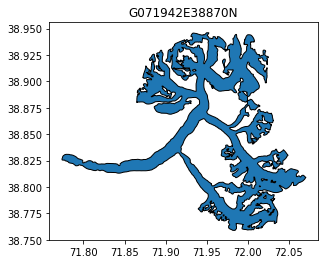

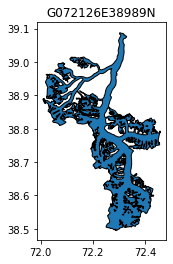

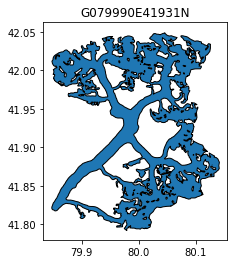

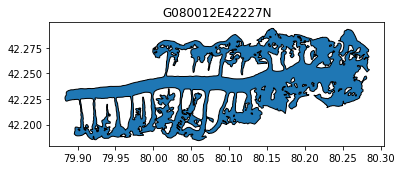

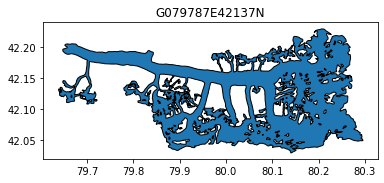

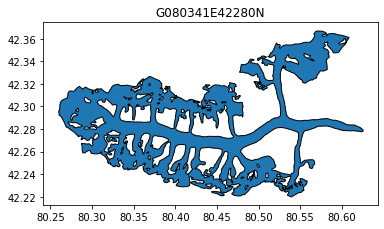

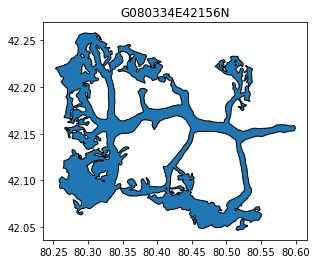

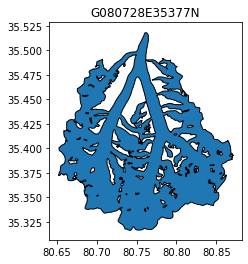

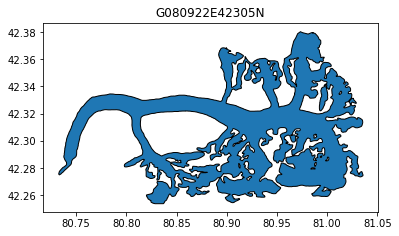

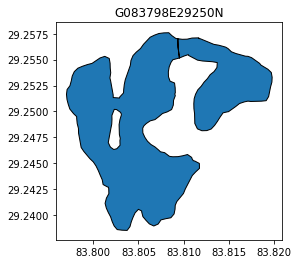

In [23]:
# plot the geometries of concern as selected from newly created RGI-file
for glac_id in prob_IDs['glac_id'].unique():
    prob_IDs.loc[prob_IDs['glac_id'] == glac_id].plot(edgecolor='k'); plt.title(glac_id.split(';')[0])


In [24]:
df_d_ref

,path,row,FID_1,Landsat_ID,yyyy,mm,dd,geometry,area
10279,146,31,10280,l71146031_03120000805,2000,8,5,"POLYGON ((80.90081 42.36556, 80.90064 42.36531...",1.247857e+08
11554,147,31,11555,LT51470312007236IKR00,2007,8,24,"POLYGON ((80.13888 41.87157, 80.13627 41.87009...",2.664734e+08
11676,147,31,11677,LT51470312007236IKR00,2007,8,24,"POLYGON ((80.36984 42.08945, 80.37042 42.08923...",1.850018e+08
12324,147,31,12325,LT51470312008223KHC01,2008,8,10,"MULTIPOLYGON (((80.31928 42.24975, 80.31901 42...",1.503360e+08
12374,147,31,12375,LT51470312008223KHC01,2008,8,10,"POLYGON ((80.27421 42.23196, 80.27351 42.23095...",1.511243e+08
12376,147,31,12377,LT51470312008223KHC01,2008,8,10,"POLYGON ((80.13926 42.03060, 80.13916 42.03089...",4.743075e+08
19111,152,33,19112,l71152033_03320000916,2000,9,16,"POLYGON ((71.86471 38.88663, 71.86473 38.88664...",1.296643e+08
27057,145,35,27058,LT51450351996256ISP00,1996,9,12,"POLYGON ((80.76113 35.49620, 80.76114 35.49582...",2.115586e+08
44748,151,33,44749,l71151033_03320010726,2001,7,26,"POLYGON ((72.45418 38.79363, 72.45446 38.79380...",6.776532e+08
83556,142,40,4926,LE71420402001272AGS00,2001,9,29,"POLYGON ((83.80930 29.25706, 83.80979 29.25701...",5.114175e+05


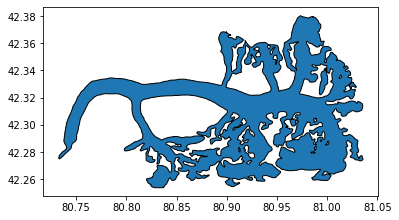

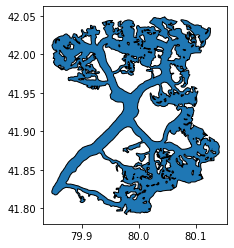

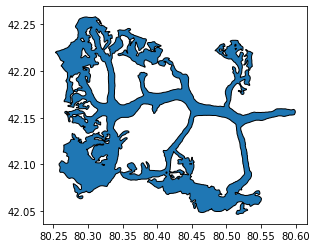

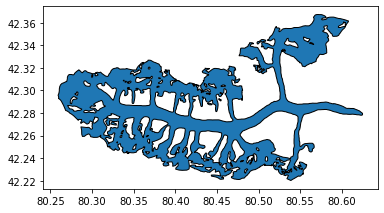

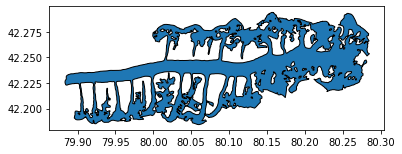

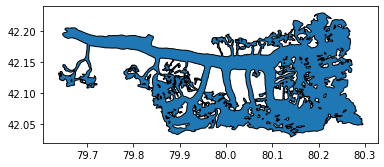

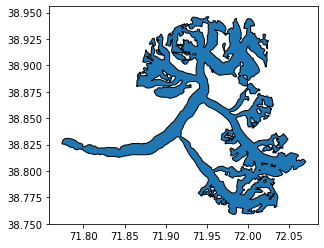

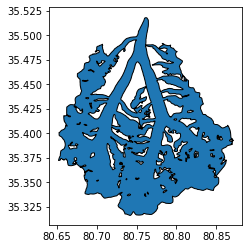

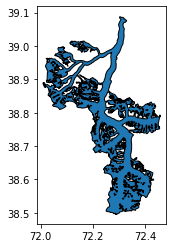

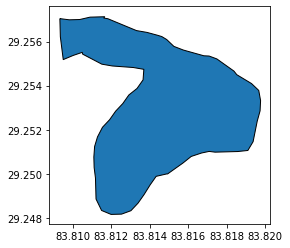

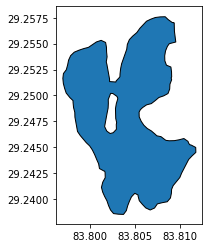

In [25]:
for i in df_d_ref.index:
      df_d_ref.loc[[i]].plot(edgecolor='k')